<a href="https://colab.research.google.com/github/maskmo/Take-Home-Problems/blob/main/take_at_home_problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM SET 2 (50 points)


![](images/fred-retail.png)

You are tasked to implement the development of a time series anomaly detection model based on [this](https://fred.stlouisfed.org/series/RSXFSN) dataset.  As you can see in the plot you should be able to identify at minimum 3 anomalies represented by the shaded regions (2001, 2008 depression and COVID recession).

Downloads the dataset as csv and ensure your code is able to read it without any user intervention other than executing the whole notebook.



### PS2.A (15 points)

Construct an LSTM autoencoder model and explain why LSTM autoencoders versus MLP / Dense autoencoders are suitable for this task. Make sure to clearly write how the LSTM autoencoder will perform anomaly detection.


LSTMs are better for time series analysis since they are costructed such that earlier neurons have greater weighting in the prediction of sequence problems than an MLP. MLPs are better for general classification or regression where inputs are mapped to outputs not related to sequencing. MLPs work well on many kinds of data while RNNs and specifically LSTMs are better suited for sequencing or time-series predictions.

In [426]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM, TimeDistributed, RepeatVector, InputLayer
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

Axes(0.125,0.11;0.775x0.77)
         DATE    RSXFSN
0  1992-01-01  130683.0
1  1992-02-01  131244.0
2  1992-03-01  142488.0
3  1992-04-01  147175.0
4  1992-05-01  152420.0
378


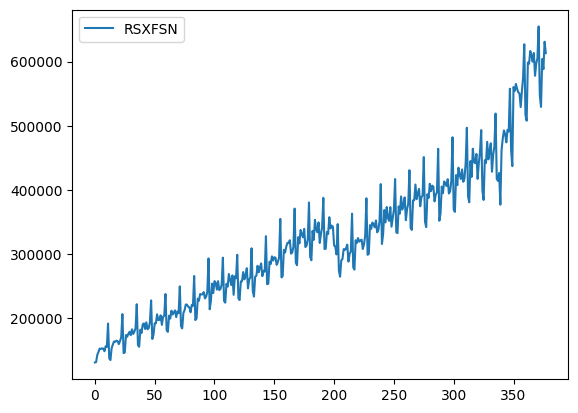

In [427]:
#data retrieval and visualization

data = pd.read_csv("/content/RSXFSN.csv")
print(data.plot())
print(data.head())
print(len(data))

In [428]:
#creating a function to partition the time series into batches of desired length with default set to 5

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X=[]
  y=[]
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [429]:
#splitting the data for time series analysis into windows of size 5 and printing the shape to ensure correct dimensions

sale = data['RSXFSN']
WINDOW_SIZE = 5
X, y = df_to_X_y(sale, WINDOW_SIZE)
X.shape, y.shape

((373, 5, 1), (373,))

In [430]:
#creating a data split method in order to easily split time series windows into desired sizes for test, training, and validation data

def data_split(X, y, train_size = 0.75, valid_size = 0.15, test_size = 0.10):
  X_train, y_train = X[:int(np.floor(train_size*len(X)))], y[:int(np.floor(train_size*len(X)))]
  X_valid, y_valid = X[int(np.floor(train_size*len(X))):int(np.floor((train_size+valid_size)*len(X)))], y[int(np.floor(train_size*len(X))):int(np.floor((train_size+valid_size)*len(X)))]
  X_test, y_test = X[int(np.floor((1-test_size)*len(X))):], y[int(np.floor((1-test_size)*len(X))):]
  return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = data_split(X,y)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((279, 5, 1), (279,), (56, 5, 1), (56,), (38, 5, 1), (38,))

In [431]:
#Creating the LSTM nearal network using sequential

model = Sequential()
model.add(InputLayer(X_train.shape[1:]))                                                            #creating an input layer to ensure correct dimensions for our dataset
model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True, activation='relu'))     #first LSTM neuron set to 128 units
model.add(Dropout(0.02))                                                                            #dropout rate of 2%
model.add(LSTM(128, activation ='relu'))                                                            #second LSTM neuron set to 128 units
model.add(Dense(64, activation ="relu"))                                                            #first dense layer with depth 64
model.add(Dropout(0.02))                                                                            #dropout rate of 2%
model.add(Dense(1, 'linear'))                                                                       #final layer, a head of depth 1 because we are only looking for the first prediction after the data ends in the time series

model.summary()                                                                                     #visualizing the data

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 5, 128)            66560     
                                                                 
 dropout_47 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_52 (LSTM)              (None, 128)               131584    
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
Total params: 206,465
Trainable params: 206,465
Non-t

In [432]:
 #hyperparameter tuning and compiling themodela using appropriate loss functions for time series predictions (ie similar to regression)

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics =[RootMeanSquaredError()])

In [433]:
#hyperparameter tuning and fitting the data using callbacks to perform early stopping and preserve validatin loss data
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 20, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')])


Epoch 1/20
9/9 [==============================] - 2s 59ms/step - loss: 23087798272.0000 - root_mean_squared_error: 151946.7031 - val_loss: 2073288832.0000 - val_root_mean_squared_error: 45533.3828
Epoch 2/20
9/9 [==============================] - 0s 21ms/step - loss: 1116928640.0000 - root_mean_squared_error: 33420.4805 - val_loss: 1718702080.0000 - val_root_mean_squared_error: 41457.2305
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: 979656256.0000 - root_mean_squared_error: 31299.4609 - val_loss: 1456792192.0000 - val_root_mean_squared_error: 38167.9453
Epoch 4/20
9/9 [==============================] - 0s 20ms/step - loss: 1014426816.0000 - root_mean_squared_error: 31850.0684 - val_loss: 1174819712.0000 - val_root_mean_squared_error: 34275.6445
Epoch 5/20
9/9 [==============================] - 0s 20ms/step - loss: 973246016.0000 - root_mean_squared_error: 31196.8906 - val_loss: 2279059968.0000 - val_root_mean_squared_error: 47739.5000
Epoch 6/20
9/9 [=========

In [434]:
#flattening the training predictions to compare them to the labels in a graph

train_predict = model.predict(X_train).flatten()
train_results = pd.DataFrame(data= {'Train Predictions': train_predict, 'Actuals': y_train})
train_results

9/9 [==============================] - 0s 5ms/step


,Train Predictions,Actuals
0,146010.75000,151849.0
1,150867.62500,152586.0
2,158073.31250,152476.0
3,161624.09375,148158.0
4,163679.96875,155987.0
...,...,...
274,426427.34375,387358.0
275,427659.78125,409453.0
276,389837.40625,397809.0
277,401908.59375,406550.0


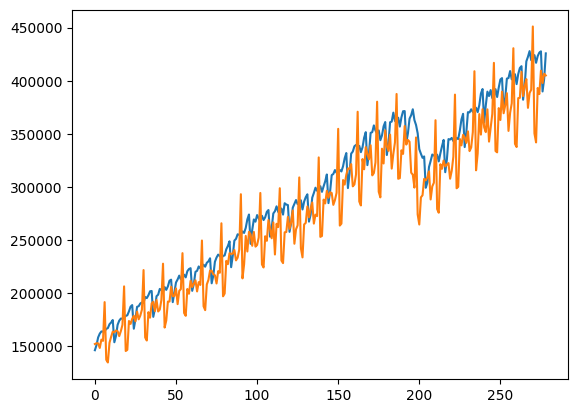

In [435]:
plt.plot(train_results)

In [436]:
#flattening the test predictions in a similar fashion to compare to its test labels
test_predict = model.predict(X_test).flatten()
test_results = pd.DataFrame(data= {'Test Predictions': test_predict, 'Actuals': y_test})
test_results

2/2 [==============================] - 0s 5ms/step


,Test Predictions,Actuals
0,492732.43750,461785.0
1,448004.93750,479784.0
2,451539.40625,492689.0
3,461029.71875,487325.0
4,468614.53125,474038.0
5,511107.21875,493601.0
6,521591.93750,490941.0
7,525480.25000,557696.0
8,526522.75000,461308.0
9,527056.12500,437031.0


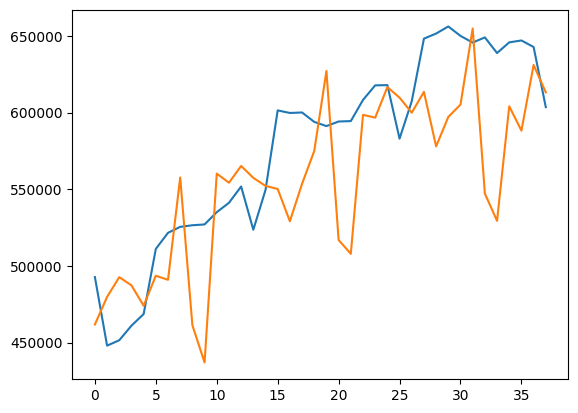

In [437]:
plt.plot(test_results)

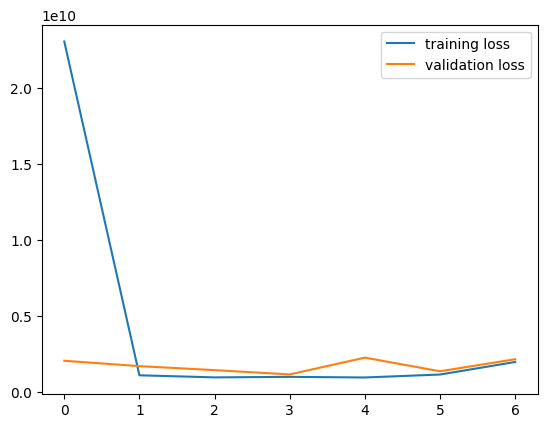

In [438]:
#graphing the validation and training loss to ensure theres no overfitting and the loss converges

plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend();

In [439]:
#evaluating the precision of the model using the mse and root mean squared error
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 2298295040.0000 - root_mean_squared_error: 47940.5352


[2298295040.0, 47940.53515625]

### PS2.B (15 points)

Train the LSTM autoencoder to a suitable metric (loss function) that will be able to reveal anomalies. Ensure you comment your code fully and clearly the training and test datasets.


Reconstruction error threshold: 287060.0


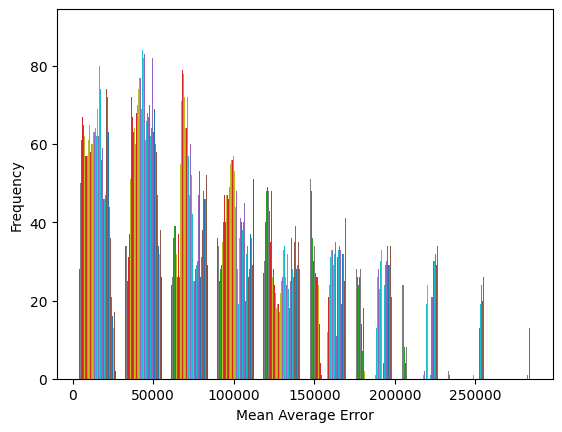

In [440]:
#graphing a histogram of the training loss in terms of mean average error to compare with the values of the testing threshold
train_mae = np.mean(np.abs(train_predict-X_train), axis=1)

plt.hist(train_mae, bins = 10)
plt.xlabel("Mean Average Error")
plt.ylabel("Frequency")

threshold = np.max(train_mae)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 142178.69249999998


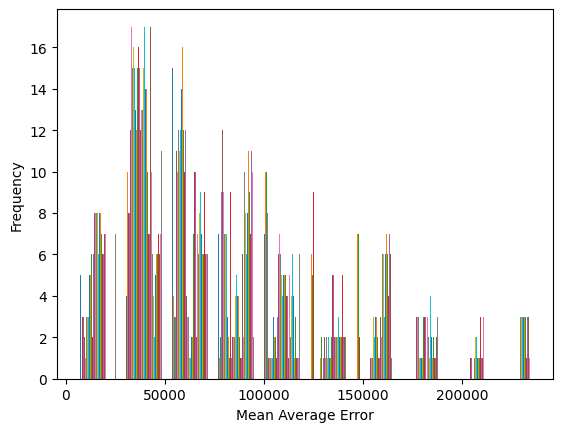

In [441]:
#plotting a histogram of test mean acerage error. The test threshold of defining anomolies will be used since the model may be bias to training or validation data since it's trainedon it
test_mae = np.mean(np.abs(test_predict-X_test), axis = 1)

plt.hist(test_mae, bins = 10)
plt.xlabel("Mean Average Error")
plt.ylabel("Frequency")

threshold = np.max(test_mae)*(0.6)
print(f'Reconstruction error threshold: {threshold}')

In [442]:
#plotting the losses in the test predictions with the threshold to visualize the anomolies in the data
test_raw = data[int(np.floor((1-0.1)*len(X)))+WINDOW_SIZE:]
test_score_df = pd.DataFrame(test_raw)
test_score_df['loss'] = np.mean(test_mae, axis = 1)
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test_raw['RSXFSN']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_raw['DATE'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['DATE'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

### PS2.C (10 points)

Plot the retail sales over time but with the anomalies highlighted with red color.

In [443]:
#plotting the losses in the training predictions with the threshold to visualize the anomolies in the training data
all_mae = train_mae
all_raw = data[:int(np.floor(0.75*len(X)))]
score_df = pd.DataFrame(all_raw)
score_df['loss'] = np.mean(all_mae, axis = 1)
score_df['threshold'] = threshold
score_df['anomaly'] = score_df['loss'] > score_df['threshold']
score_df['Close'] = data['RSXFSN']

fig = go.Figure()
fig.add_trace(go.Scatter(x=all_raw['DATE'], y=score_df['loss'], name='Loss'))
fig.add_trace(go.Scatter(x=score_df['DATE'], y=score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Loss vs. Threshold')
fig.show()

In [444]:
#defining the anomolies as one dataframe in order to have them graphed as points against the original data. The test and training/validation anomolies were combined
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape
anomalies_train = score_df.loc[score_df['anomaly'] == True]
anomalies_train = anomalies_train.append(anomalies)

<ipython-input-444-cdb036f0466a>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [445]:
#the final plot of the anomolies visualized against the original data. It seems the model has an unpredictable loss because some anomolies are placed in areas with less variation
#although, it makes sense the model will identify anomolies to the erly datapoints since the model had started its training on those points
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['DATE'], y=data['RSXFSN'], name='Sale Price'))
fig.add_trace(go.Scatter(x=anomalies_train['DATE'], y=anomalies_train['RSXFSN'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

## PS2.D (10 points)

Explain what the hidden state of the LSTM represents.  

Explain in this cell  ...

The hidden state of an LSTM represents the output of the previous neurons weights as well as the weighting of the updated new hidden state. If there is anouther hidden state after, the cumulative output will then have an influence on the new hidden state. The number of previous hidden states' weightings can be toggle, just I I set them to 10 in the split function I created.